In [2]:
#!/usr/bin/env python3
import os
import sys
import argparse
import numpy as np
import re
from glob import glob
import time
import importlib
import yaml

sys.path.append('./DeepLagrangianFluids')
sys.path.append('./DeepLagrangianFluids/scripts')
from datasets.dataset_reader_physics import read_data_val
from fluid_evaluation_helper import FluidErrors
import tensorflow as tf

2023-03-06 09:50:24.179884: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:

parser = argparse.ArgumentParser(
    description=
    "Runs a fluid network on the given scene and saves the particle positions as npz sequence",
    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("trainscript",
                    type=str,
                    help="The python training script.")
parser.add_argument(
    "--weights",
    type=str,
    required=True,
    help=
    "The path to the .h5 network weights file for tensorflow ot the .pt weights file for torch."
)
parser.add_argument("--num_steps",
                    type=int,
                    default=250,
                    help="The number of simulation steps. Default is 250.")
# parser.add_argument("--scene",
#                     type=str,
#                     required=True,
#                     help="A json file which describes the scene.")
# parser.add_argument("--output",
#                     type=str,
#                     required=True,
#                     help="The output directory for the particle data.")
parser.add_argument("--write-ply",
                    action='store_true',
                    help="Export particle data also as .ply sequence")
parser.add_argument("--write-bgeo",
                    action='store_true',
                    help="Export particle data also as .bgeo sequence")
parser.add_argument("--device",
                    type=str,
                    default='cuda',
                    help="The device to use. Applies only for torch.")

args = parser.parse_args("--weights DeepLagrangianFluids/scripts/train_network_tf_WBCSPH/checkpoints/ckpt-50000.index train_network_tf.py".split())
print(args)

module_name = os.path.splitext(os.path.basename(args.trainscript))[0]
sys.path.append('.')
trainscript_module = importlib.import_module(module_name)

# with open(args.scene, 'r') as f:
#     scene = json.load(f)

Namespace(trainscript='train_network_tf.py', weights='DeepLagrangianFluids/scripts/train_network_tf_WBCSPH/checkpoints/ckpt-50000.index', num_steps=250, write_ply=False, write_bgeo=False, device='cuda')


In [4]:
print(model.filter_extent)

NameError: name 'model' is not defined

In [9]:
model = trainscript_module.create_model()
model.init()
# model.load_weights(args.weights, by_name=True)
print(model.convs[0].weights[0][0][0][0][:4,:4])
checkpoint = tf.train.Checkpoint(step=tf.Variable(0), model=model)
checkpoint.restore(os.path.splitext(args.weights)[0]).expect_partial()
print(model.convs[0].weights[0][0][0][0][:4,:4])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/winchenbach/anaconda3/envs/DeepLagrangianFluids/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
2023-03-06 09:50:59.800166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


tf.Tensor(
[[-0.04418419  0.02187239 -0.03529699 -0.02832275]
 [-0.02565796  0.03288536 -0.03020257  0.00133533]
 [-0.00887372 -0.04310113 -0.02542785 -0.01855893]
 [-0.00348591 -0.0062878  -0.01394944 -0.01582402]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[ 0.6438158   0.21930568  0.6382179  -0.23451976]
 [-0.2521801   0.06656204  0.48136368 -0.1941132 ]
 [ 0.5902122   0.10181598  0.5007628  -0.1605522 ]
 [ 0.7066873   0.1032549   1.1942687   0.4393611 ]], shape=(4, 4), dtype=float32)


2023-03-06 09:51:00.925754: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-06 09:51:00.925816: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()
from rbfNet import *
from tqdm.notebook import trange, tqdm

In [6]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)
def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
#             print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
#         print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length

extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
# simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)

frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% ('/'.join(s.split('/')[-2:]).split('.')[0], length, numFluids, numBoundary))

simFiles [list] = ['test/sim_0006.hdf5', 'test/sim_0024.hdf5', 'test/sim_0049.hdf5', 'test/sim_0060.hdf5', 'test/sim_0061.hdf5', 'test/sim_0062.hdf5', 'test/sim_0063.hdf5', 'test/sim_0065.hdf5', 'test/sim_0066.hdf5', 'test/sim_0067.hdf5', 'test/sim_0068.hdf5', 'test/sim_0069.hdf5', 'train/sim_0000.hdf5', 'train/sim_0002.hdf5', 'train/sim_0003.hdf5', 'train/sim_0004.hdf5', 'train/sim_0005.hdf5', 'train/sim_0006.hdf5', 'train/sim_0007.hdf5', 'train/sim_0010.hdf5', 'train/sim_0012.hdf5', 'train/sim_0013.hdf5', 'train/sim_0014.hdf5', 'train/sim_0016.hdf5', 'train/sim_0018.hdf5', 'train/sim_0019.hdf5', 'train/sim_0020.hdf5', 'train/sim_0021.hdf5', 'train/sim_0022.hdf5', 'train/sim_0023.hdf5', 'train/sim_0024.hdf5', 'train/sim_0026.hdf5', 'train/sim_0028.hdf5', 'train/sim_0029.hdf5', 'train/sim_0030.hdf5', 'train/sim_0031.hdf5', 'train/sim_0032.hdf5', 'train/sim_0033.hdf5', 'train/sim_0034.hdf5', 'train/sim_0036.hdf5', 'train/sim_0039.hdf5', 'train/sim_0040.hdf5', 'train/sim_0043.hdf5', 'tra

  0%|          | 0/59 [00:00<?, ?it/s]

simulation test/sim_0006 has  300 frames,  1104 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0024 has  300 frames,  7728 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0049 has  200 frames, 16928 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0060 has 3200 frames,  6034 fluid ptcls, 18326 bdy ptcls
simulation test/sim_0061 has 3200 frames,  2009 fluid ptcls, 18288 bdy ptcls
simulation test/sim_0062 has 3200 frames, 11259 fluid ptcls, 11948 bdy ptcls
simulation test/sim_0063 has 3200 frames,  8371 fluid ptcls, 13896 bdy ptcls
simulation test/sim_0065 has 3200 frames, 11530 fluid ptcls, 10863 bdy ptcls
simulation test/sim_0066 has 3200 frames, 13484 fluid ptcls, 15103 bdy ptcls
simulation test/sim_0067 has 3200 frames, 10824 fluid ptcls, 13261 bdy ptcls
simulation test/sim_0068 has 3200 frames,  8851 fluid ptcls, 11829 bdy ptcls
simulation test/sim_0069 has 3200 frames,  8864 fluid ptcls,  8579 bdy ptcls
simulation train/sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcl

<IPython.core.display.Javascript object>


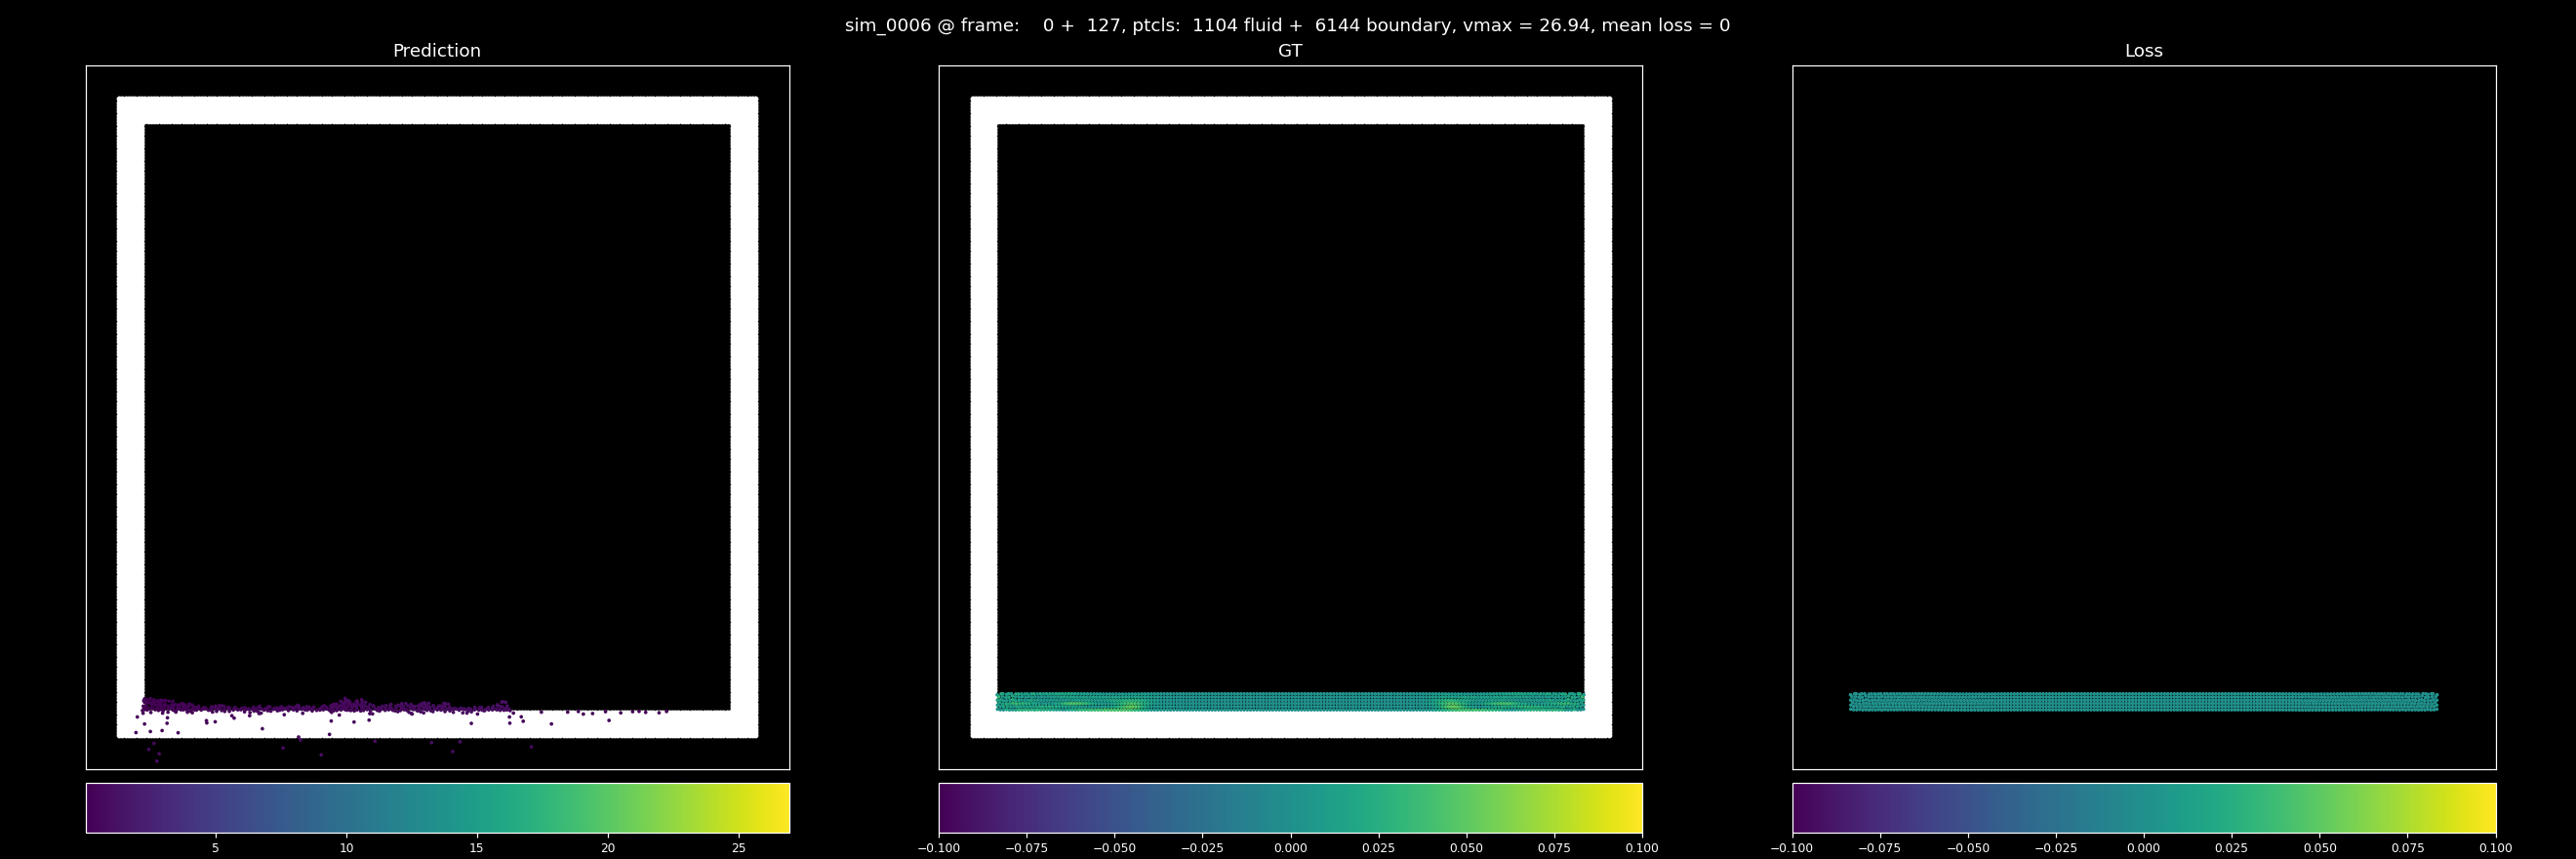

/home/winchenbach/anaconda3/envs/DeepLagrangianFluids/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='fileName', options=('test/sim_0006.hdf5', 'test/sim_0024.hdf5', 't…

<function __main__.plotNetwork(fileName, frame)>

In [7]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter0.set_offsets(inputData['boundaryPosition'][:,:2])
        bdyScatter1.set_offsets(inputData['boundaryPosition'][:,:2])
#         bdyScatter2.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    sc0.set_offsets(positions)
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    sc1.set_offsets(positions)
    sc1.set_array(data)
    cbar1.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    sc2.set_offsets(positions)
    sc2.set_array(data)
    cbar2.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    
#     axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.suptitle('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
   

fig, axis = plt.subplots(1, 3, figsize=(24,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-0.05,1.05)
axis[0,1].set_ylim(-0.05,1.05)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-0.05,1.05)
axis[0,2].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

bdyScatter0 = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
bdyScatter1 = axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
# bdyScatter2 = axis[0,2].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )

sc0 = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar0 = fig.colorbar(sc0, cax=cax1,orientation='horizontal')
cbar0.ax.tick_params(labelsize=8) 

sc1 = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar1 = fig.colorbar(sc1, cax=cax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8) 

sc2 = axis[0,2].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar2 = fig.colorbar(sc2, cax=cax1,orientation='horizontal')
cbar2.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
axis[0,0].set_title('Prediction')
axis[0,1].set_title('GT')
axis[0,2].set_title('Loss')
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
axis[0,1].set_xticks([], [])
axis[0,1].set_yticks([], [])
axis[0,2].set_xticks([], [])
axis[0,2].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)

In [10]:
imageFolder = 'cconv(L)'
os.makedirs(imageFolder)
# for i in tqdm(range(0, frameCount, 8), leave = False):
#     plotNetwork(simulationFile, i)
imagePath = '%s/%04d.png' % (imageFolder, 0)
plt.savefig(imagePath, dpi = 200)

In [11]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
# params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']

pr_pos = tf.convert_to_tensor(predictedPositions.detach().cpu().numpy())
pr_vel = tf.convert_to_tensor(predictedVelocities.detach().cpu().numpy())
acc = tf.convert_to_tensor(inputData['fluidGravity'].detach().cpu().numpy())

box = tf.convert_to_tensor(boundaryPositions.detach().cpu().numpy())
box_normals = tf.convert_to_tensor(boundaryFeatures.detach().cpu().numpy())

pr_pos = tf.concat ([pr_pos, tf.zeros((pr_pos.shape[0],1))], axis = 1)
pr_vel = tf.concat ([pr_vel, tf.zeros((pr_pos.shape[0],1))], axis = 1)
acc = tf.concat ([acc, tf.zeros((pr_pos.shape[0],1))], axis = 1)

box = tf.concat ([box, tf.zeros((box.shape[0],1))], axis = 1)
# box_normals = tf.concat ([box_normals, tf.zeros((box_normals.shape[0],1))], axis = 1)

print(pr_pos.shape)
print(pr_vel.shape)
print(box.shape)
print(box_normals.shape)
print(acc.shape)


for i in range(1, 128):
    inputs = (pr_pos, pr_vel, None, box, box_normals, acc)
    pr_pos, pr_vel = model(inputs)    
    
    gt = getGroundTruth(fileName, prevFrame + i)
#     predictedPositions, predictedVelocities, loss = runRbfNetwork(predictedPositions, predictedVelocities, attributes['dt'], 1, params, gt, True)
    
    data = np.linalg.norm(pr_vel.numpy(),axis=1)    
    sc0.set_offsets(pr_pos.numpy())
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    
    gtdata = np.linalg.norm(gt[1].detach().cpu().numpy(), axis = 1)
    sc1.set_offsets(gt[0].detach().cpu().numpy())
    sc1.set_array(gtdata)
    sc2.set_offsets(gt[0].detach().cpu().numpy())
#     sc2.set_array(loss.detach().cpu().numpy())
    
    fig.suptitle('%s @ frame: %4d + %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g, mean loss = %.4g' % (prevFile.split('/')[-1].split('.')[0], prevFrame, i, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data), 0.))
    fig.canvas.draw()
    fig.canvas.flush_events()
    imagePath = '%s/%04d.png' % (imageFolder, i)
    plt.savefig(imagePath, dpi = 200)
    


/home/winchenbach/dev/datasets/WBCSPH2Dc/test/sim_0006.hdf5
0
(1104, 3)
(1104, 3)
(6144, 3)
(6144, 3)
(1104, 3)
